# Interactive plot
> The interactive plot does not work in Jupyter Lab because `%matplotlib notebook` is not supported there. So execute this notebook in Jupyter Notebook instead.

In [1]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

In [2]:
# Change directory to src to import functions from load.py
%cd "../src"
from load import get_values_sql, compressed2img, object2numeric_array

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/src


## Global variables

In [3]:
db_path = r"../SingleSphere02.db"   # Path of the data in Google Drive or in your local machine
n_voxels = 64
voxel_size = 10 / 64     # in m
extent = [0, 10, 0, 10]  # in m
n_dim = 2

POINT = np.array([
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
], dtype=np.bool_)


In [4]:
worlds = get_values_sql(file=db_path, table='worlds')
obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
print(f"Obstacle images dimension: {obstacle_images.shape}")

Obstacle images dimension: (5000, 64, 64)


## Local functions

In [5]:
def get_point_img(x, y, img_shape):
    r = POINT.shape[0]//2
    x = min(max(r, x), img_shape[0]-r)
    y = min(max(r, y), img_shape[1]-r)
    img = np.zeros(img_shape, dtype=np.bool_)
    
    img[y-r:y+r+1, x-r:x+r+1] = POINT
    
    return np.expand_dims(img, axis=-1)

def generate_img(img_obst, img_start, img_end, img_path):
    img_shape = (*img_obst.shape[:-1], 3)

    img = np.full(img_shape, 1-img_obst, dtype=np.float32)
    img[:, :, [1, 2]] -= img_start                  # Start pos in red channel
    img[:, :, [0, 2]] -= img_end                    # End pos in green channel
    img[:, :, [1, 2]] -= 0.75*img_path              # Predicted path in red channel
    np.clip(img, 0.0, 1.0, out=img)
    return img

def plot_img(ax, img, path_vector=None, xticks=None, yticks=None):
    ax.clear()
    ax.imshow(img, origin="lower", extent=extent)
    if path_vector is not None:
        py, px = path_vector.T
        ax.plot(px, py, color="y", marker="o")
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.grid(True, alpha=0.25)

## Loading pretrained model

In [24]:
model_path = r"../results/soft_dice_17.06.2021_06.21/model.tf"
# model_path = r"../results/combined_loss_13.07.2021_13.34/model.tf"
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_path, compile=False)

We have two types of U-DenseNet models:
1. Image-to-image model
2. Image-to-coordinate model with auxiliary output (path coordinates)  

Based on the model type, we describe the pre- and postprocessing functions in the cell below. 

In [7]:
if len(model.outputs) == 1:                          # Image-to-Image model
    prepare_input = lambda o, s, e: np.array([np.concatenate([o, s + e], axis=-1)])
    process_output = lambda x: (x[0], None)
else:                                                # 
    prepare_input = lambda o, s, e: np.array([np.concatenate([o, s, e], axis=-1)])
    process_output = lambda x: (x[0][0], x[1][0])

In [8]:
img_shape = (n_voxels, n_voxels)
xticks = yticks = np.arange(extent[1]+1)
start_point = (3, 3)
end_point = (6, 6)

## Interactive plot
In the plot below, you can click on the image to specify <span style="color:red">start</span> and <span style="color:green">end</span> points.  

### Controls
- **Left-click**: assigns the start point 
- **Wheel-click**: changes the obstacle configuration
- **Right-click**: assigns the end point.

<IPython.core.display.Javascript object>


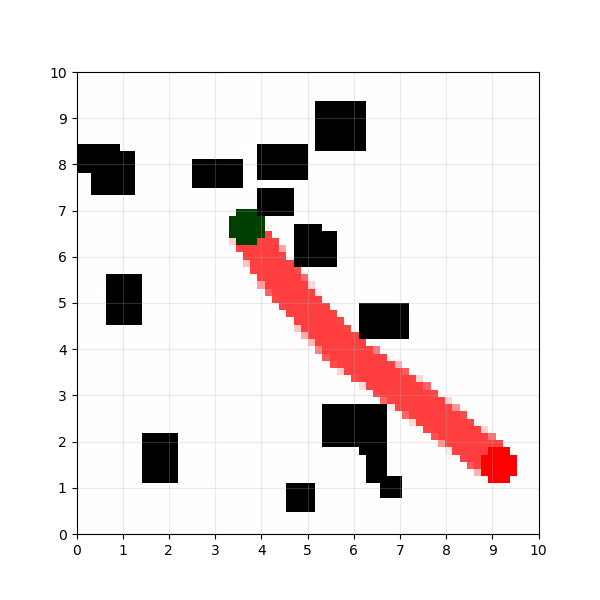

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

world_index = np.random.choice(len(obstacle_images))
obst_img = np.expand_dims(obstacle_images[world_index], axis=-1)
# Generate start, end and path images
start_img = get_point_img(*start_point, img_shape)
end_img = get_point_img(*end_point, img_shape)
input_img = prepare_input(obst_img, start_img, end_img)
output = model.predict(input_img)
path_img, path_vector = process_output(output)

# Generate a single image from obstacle, start, end and path images
img = generate_img(obst_img, start_img, end_img, path_img)
plot_img(ax, img, path_vector, xticks, yticks)


def onclick(event):
    """
    Callback function to handle mouse event on the image
    """
    global obst_img, start_point, end_point, start_img, end_img, path_img
    e = event
    # Convert [0 - 10] coordinate values into [0 - 64] pixel values
    x = round(event.xdata/voxel_size)
    y = round(event.ydata/voxel_size)
    
    # Assign given xy coordinate to start or end point
    if event.button == 1:               # Left click
        start_point = (x, y)
        start_img = get_point_img(*start_point, img_shape)
    elif event.button == 2:             # Wheel click 
        world_index = np.random.choice(len(obstacle_images))
        obst_img = np.expand_dims(obstacle_images[world_index], axis=-1)
    elif event.button == 3:             # Right click
        end_point = (x, y)
        end_img = get_point_img(*end_point, img_shape)
        
    input_img = prepare_input(obst_img, start_img, end_img)
    output = model.predict(input_img)
    path_img, path_vector = process_output(output)
    
    img = generate_img(obst_img, start_img, end_img, path_img)
    plot_img(ax, img, path_vector, xticks, yticks)
    
# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)